# Stocks data ingestion

In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-11-08 11:26:21,819 [info] loaded project stocks from None or context and saved in MLRun DB


> <b> Steps </b>
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

## Creating a feature set and declaring the graph

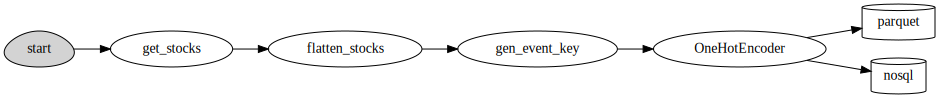

In [2]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
from mlrun.datastore.targets import ParquetTarget
import yahoo_fin.stock_info as si

info_set = fstore.FeatureSet("stocks", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
n_tickers = 10


info_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker2onehot':{ticker:str(idx) for idx,ticker in enumerate(si.tickers_sp500()[:n_tickers])}}))\
    
# Setting default targets (nosql & parquet)
info_set.set_targets([ParquetTarget(flush_after_seconds=5)], with_defaults=False) 
info_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [3]:
import os 
import datetime
# code must be present when ingestint locally
from src.stocks import *

# ingesting dummy (A MUST) 
name = 'stocks-dummy'
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(info_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':59,
                                      'end_delta':31,
                                      'interval':'5m',
                                      'n_stocks':n_tickers}),
              overwrite=True)

,Datetime,Open,High,Low,Close,Volume,ticker2onehot_A,ticker2onehot_ABBV,ticker2onehot_ABT,ticker2onehot_ABMD,ticker2onehot_AAPL,ticker2onehot_AAP,ticker2onehot_ACN,ticker2onehot_ABC,ticker2onehot_ACGL,ticker2onehot_AAL
ticker,,,,,,,,,,,,,,,,
A,2022-11-08 11:26:44.928260+00:00,137.529999,137.889999,137.229996,137.869995,30482,1,0,0,0,0,0,0,0,0,0
A,2022-11-08 11:26:44.928959+00:00,137.764999,138.350006,137.577499,137.820007,12843,1,0,0,0,0,0,0,0,0,0
A,2022-11-08 11:26:44.929374+00:00,137.770004,137.889999,137.449997,137.500000,8385,1,0,0,0,0,0,0,0,0,0
A,2022-11-08 11:26:44.929719+00:00,137.509995,137.759995,137.505997,137.585007,15928,1,0,0,0,0,0,0,0,0,0
A,2022-11-08 11:26:44.930051+00:00,137.580307,137.789993,137.580307,137.585007,8339,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACN,2022-11-08 11:26:50.389660+00:00,258.350006,258.970001,258.309998,258.964996,24387,0,0,0,0,0,0,1,0,0,0
ACN,2022-11-08 11:26:50.389959+00:00,259.019989,259.510010,258.920013,259.359985,28526,0,0,0,0,0,0,1,0,0,0
ACN,2022-11-08 11:26:50.390267+00:00,259.279999,259.320007,258.859985,259.010010,35677,0,0,0,0,0,0,1,0,0,0


In [4]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
info_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance', 'graphviz'], filename='src/stocks.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False)

In [5]:
# Deploying
info_set_endpoint, function = fstore.deploy_ingestion_service_v2(featureset=info_set, run_config=run_config)

> 2022-11-08 11:26:51,210 [info] Starting remote function deploy
2022-11-08 11:26:51  (info) Deploying function
2022-11-08 11:26:51  (info) Building
2022-11-08 11:26:51  (info) Staging files and preparing base images
2022-11-08 11:26:51  (info) Building processor image
2022-11-08 11:28:28  (info) Build complete
2022-11-08 11:28:42  (info) Function deploy complete
> 2022-11-08 11:28:42,617 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


## Testing ingestion service

In [6]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(info_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':29,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':n_tickers})
t.text

'{"id": "de953d3c-d044-4d7c-94b8-d4149810379c"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [10]:
import datetime

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

body = {'ticker':['stocks'],
        'Datetime': now,
        'start_delta':1,
        'end_delta':0,
        'interval':'5m',
        'n_stocks':n_tickers}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':info_set_endpoint, 'body': body}, schedule='*/10 14-18 * * *')

> 2022-11-08 12:09:07,246 [info] starting run ingestion-service-stocks-ingestion_service_invoker uid=30c8ee37ebe244138d900d6449deb133 DB=http://mlrun-api:8080
> 2022-11-08 12:09:10,779 [info] task scheduled, {'schedule': '*/10 14-18 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-stocks-ingestion_service_invoker'}
